# Data Description
- https://www.kaggle.com/datasets/blastchar/telco-customer-churn

The dataset includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

# Data Overview

`Context`:
- Predict behavior to retain customers

`Dataset`:
- IBM Telco Customer Churn

`Key Takeaways`:
- Classification problem
- Imbalance data
- Thresholding

`Workflow/ Pipelines` (better clarity the steps at the beginning, be organized, don't disappear into EDA for 30 minutes):
- Quick data overview (define target + leakage; check data types, missingness, duplicates; decide data split)
- Lightweight EDA (check data distributions, data correlation)
- A few interpretable engineered features

- Lightweight baseline models: 
1) split the data (split: stratified/ time/ group, avoid leakage)
2) preprocess data (ColumnTransformer)
3) apply logistic regression model
4) use cross-validation (stratified) with ROC-AUC / PR-AUC (primary if imbalanced)
5) work on calibration and thresholding
6) sanity-check with a model, and explain with coefficients

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [4]:
data.shape

(7043, 21)

In [5]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
data.drop(columns=["customerID", "Churn"]).dtypes.value_counts()

# 16 categorical features
# 3 numerical features

object     16
int64       2
float64     1
Name: count, dtype: int64

In [8]:
# SeniorCitizen: int64 -> object
print("Senior Citizen Type:", data.SeniorCitizen.dtypes)

# TotalCharges: object -> int64
print("Total Charges Type:", data.TotalCharges.dtypes)

# Churn: Yes, No -> 1, 0
data.Churn.value_counts()

Senior Citizen Type: int64
Total Charges Type: object


Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 0.27


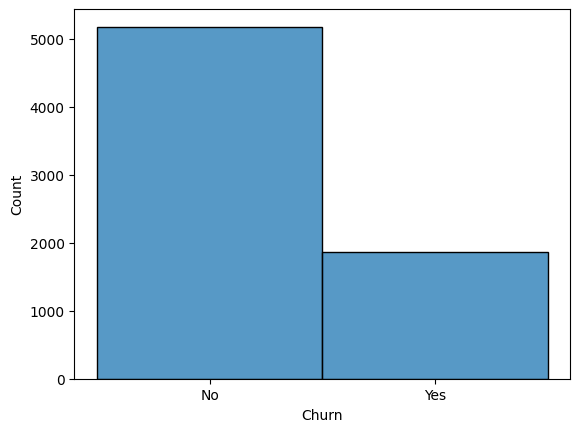

In [9]:
# Problem:
# The churn is imbalanced

# Business Target:
# 1. Higher Recall: Catch more churners
# 2. Higher Precision: Avoid unnecessary offers

# Tech Solutions:
# 1. Evaluation: Aviod using accuracy, instead use Precision-Recall AUC (focus on positive cases)
# 2. Data Split: Stratified Train/ Validation/ Test splits, so the churn rate stays consistent across the folds
# 3. Loss function: class_weight = 'balanced' (Enfore model to pay more attention to churners)
# 4. Threshold: Tune the decision threshold on validation predictions

print("Churn Rate:", round(len(data[data.Churn=='Yes'])/len(data), 2))
sns.histplot(data.Churn);

# Data Cleaning

In [10]:
# Convert data types
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
data["SeniorCitizen"] = data["SeniorCitizen"].astype(str)
data["churn"] = (data["Churn"].astype(str)=="Yes").astype(int)
data.drop(columns=["Churn", "customerID"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [11]:
# Check missing values
# Will handle the missing values when building pipeline preprocessor
missing = data.isna().mean().sort_values(ascending=False)
missing.head()

TotalCharges      0.001562
gender            0.000000
SeniorCitizen     0.000000
MonthlyCharges    0.000000
PaymentMethod     0.000000
dtype: float64

# Lightweight EDA
- Keep EDA short and decision-oriented (Churn Rate)
- A couple of churn-by-segment summaries
- Check numeric distributions

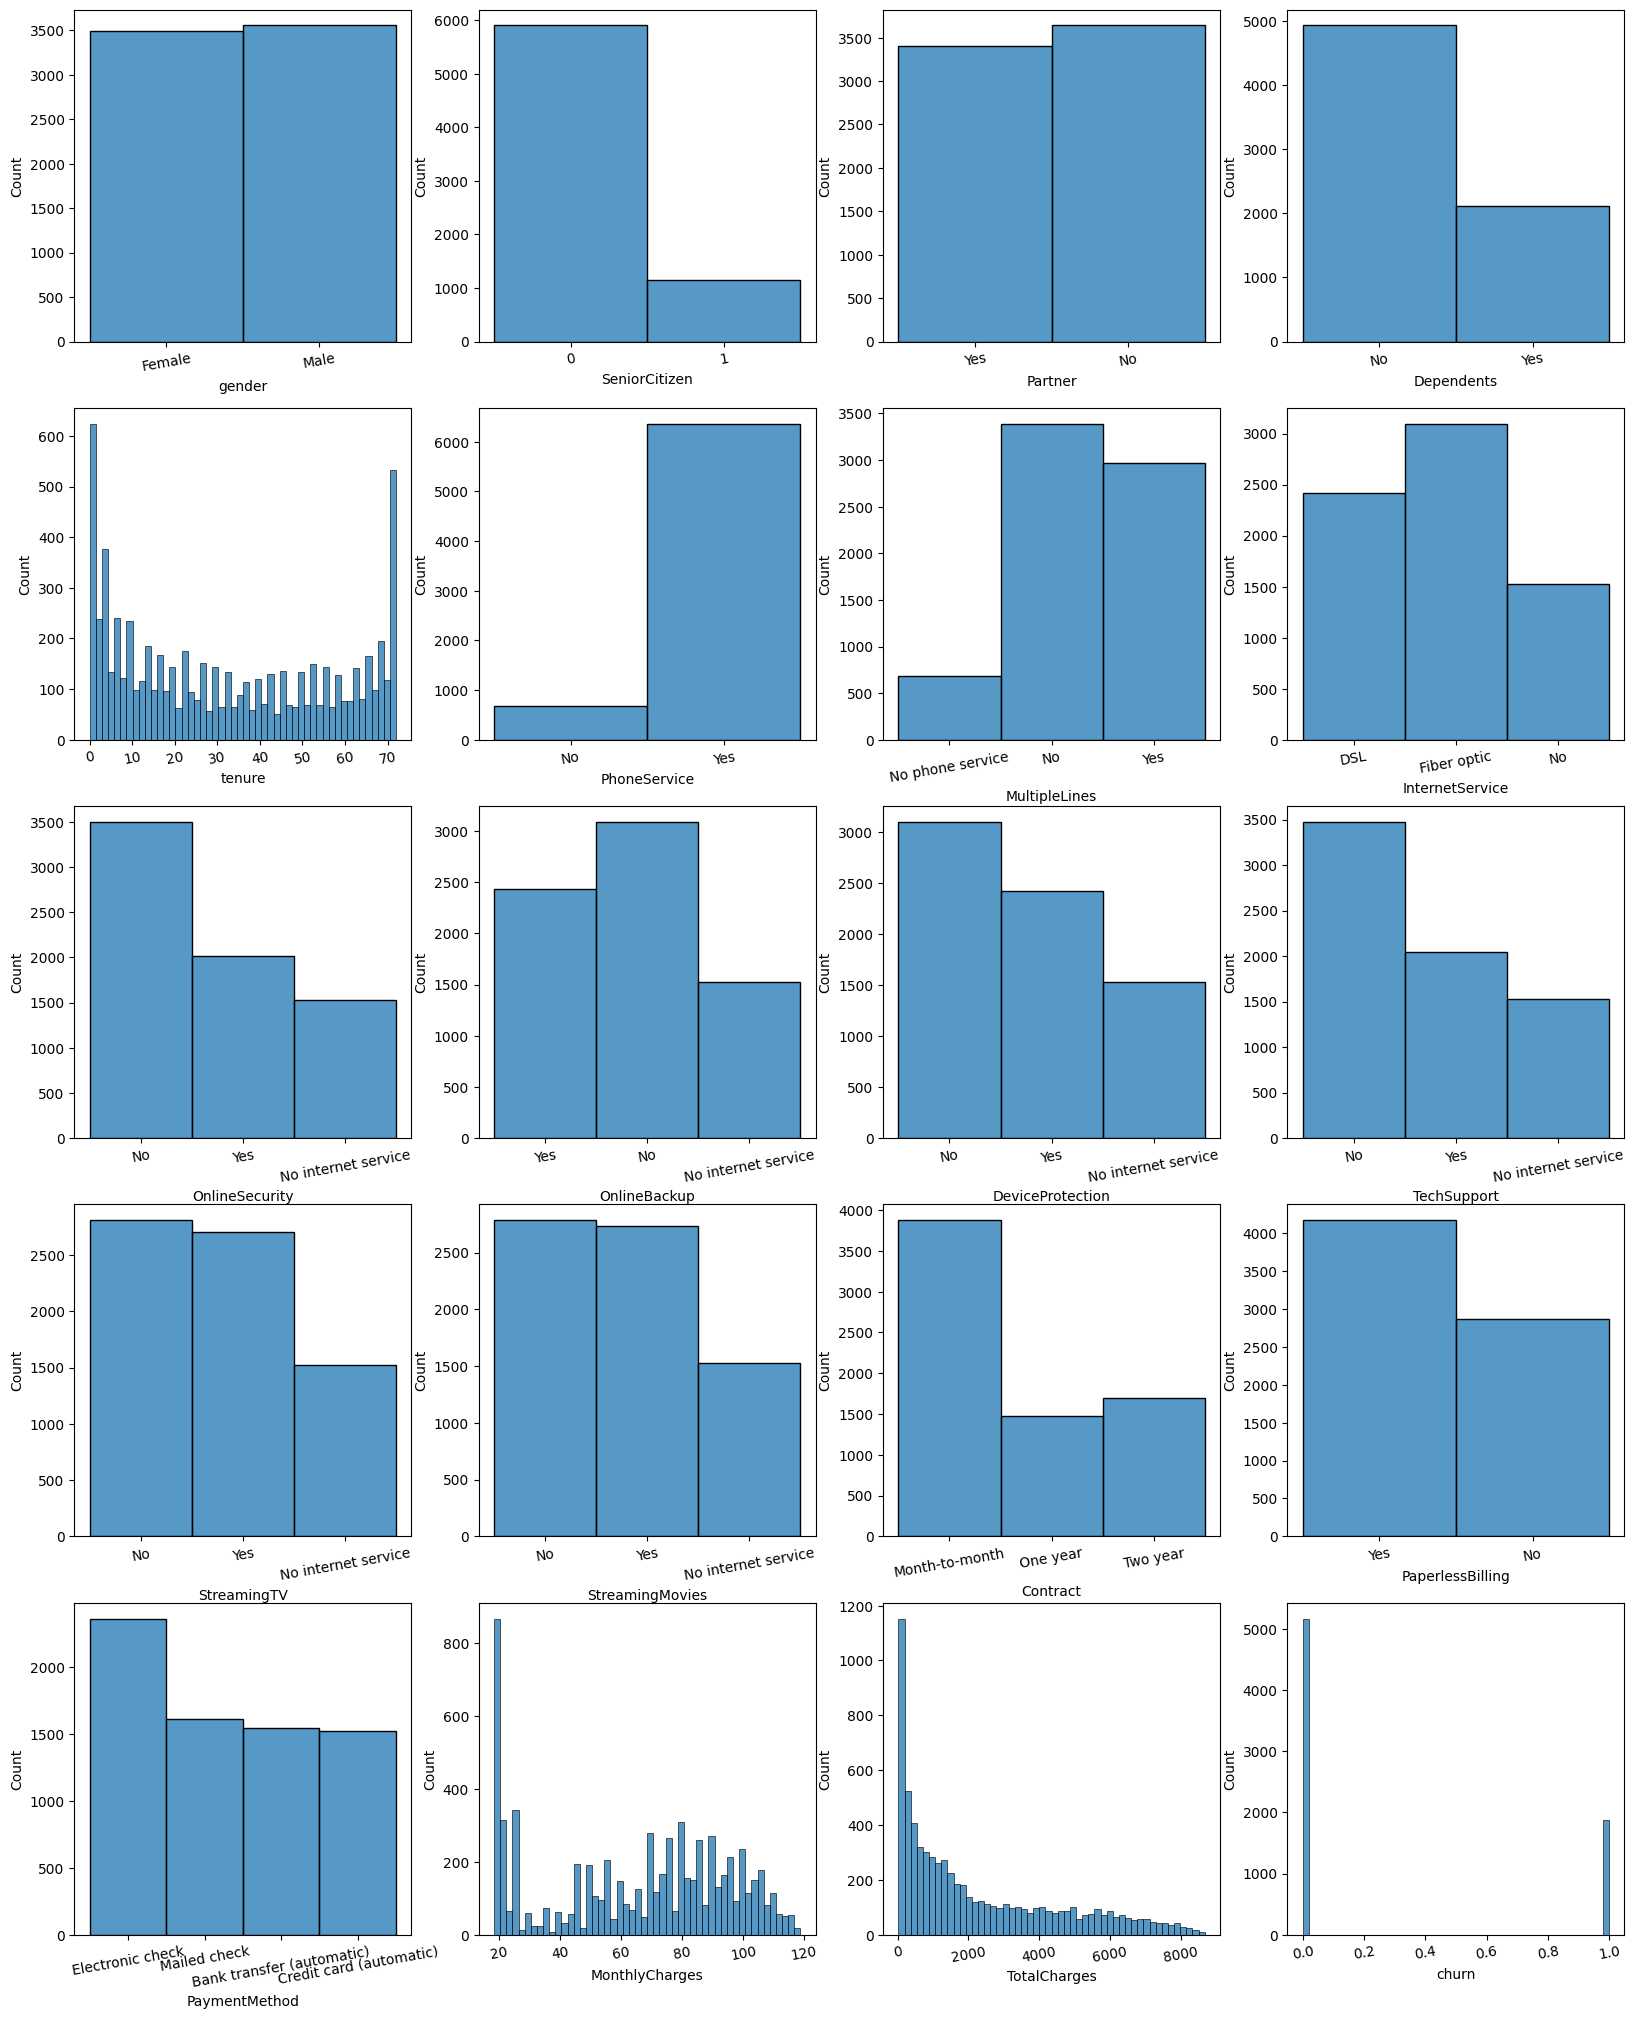

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt

# data distribution
n = data.shape[1]
size = 5
rows = math.ceil(np.sqrt(n))
cols = math.ceil(n/rows)
fig, axes = plt.subplots(rows, cols, figsize=(cols*size,rows*size))
axes = axes.flatten()
for i, feature in enumerate(data.columns.to_list()):
  ax = axes[i]
  sns.histplot(data[feature], bins=50, ax=ax)
  ax.tick_params(axis='x', rotation=10)

for j in range(i+1, n):
  ax = axes[j]
  fig.delaxes(ax)
plt.show()

In [13]:
# data distribution when churn=True
# data distributin when churn=False
data.dtypes.value_counts()
categorical_features = list(data.select_dtypes(["object"]).columns)
print(categorical_features)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


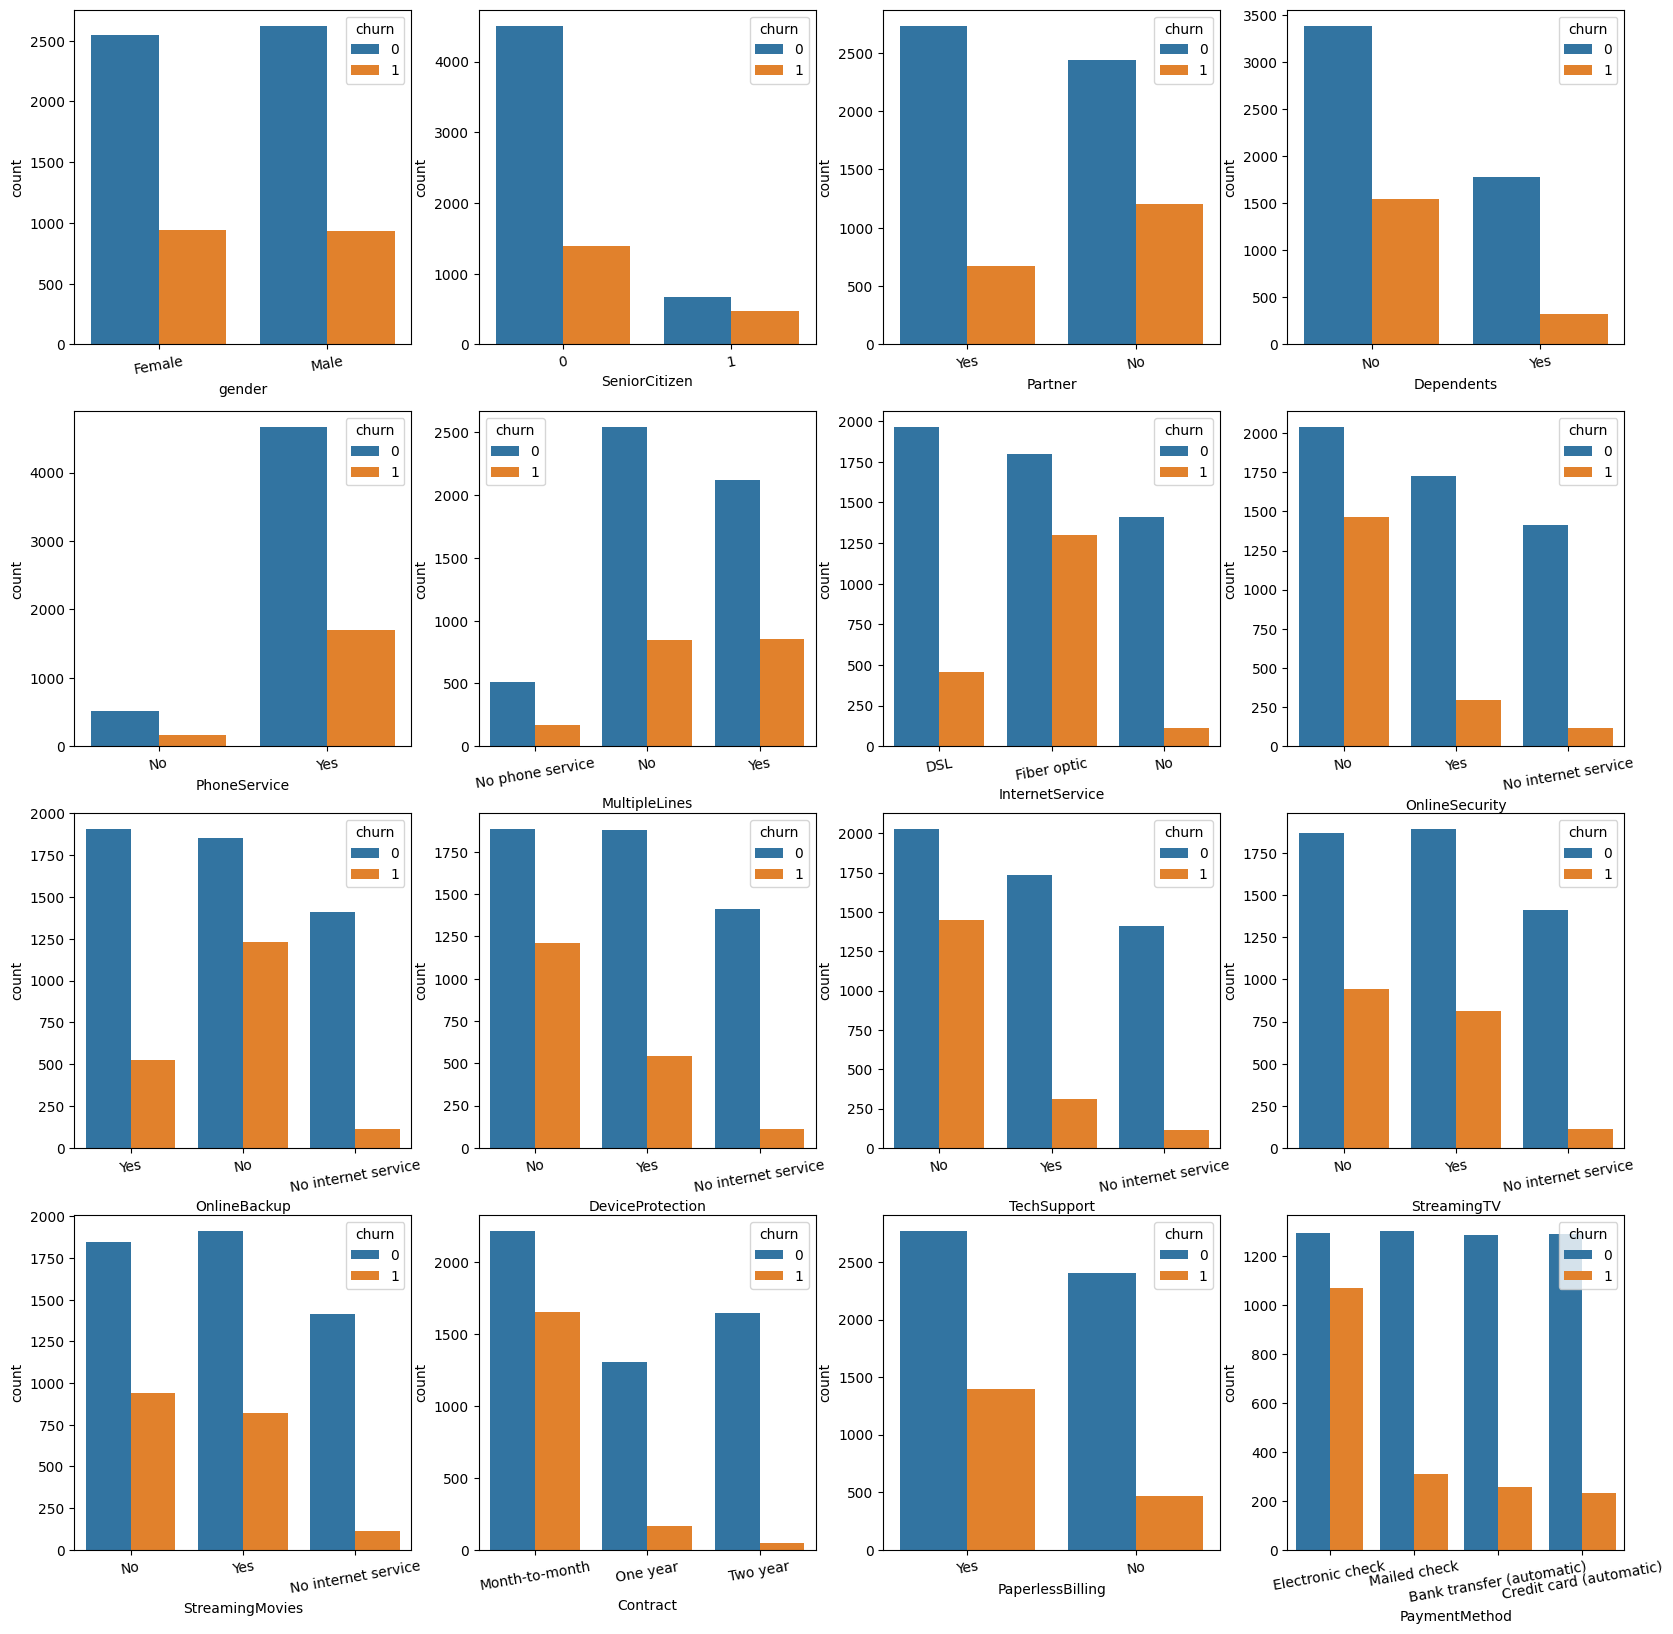

In [14]:
size = 5
n = len(categorical_features)
rows = math.ceil(np.sqrt(n))
cols = math.ceil(n/rows)

fig, axes = plt.subplots(rows, cols, figsize=(cols*size,rows*size))
axes = axes.flatten()

for i, category in enumerate(categorical_features):
  ax = axes[i]
  sns.countplot(x=category, hue="churn", data=data, ax=ax)
  ax.tick_params(axis='x', rotation=10)
plt.show()

In [15]:
for feature in categorical_features:
  seg = data.groupby(feature)["churn"].mean().sort_values(ascending=False)
  # print("***")
  # print(seg)

# Feature Engineering

In [16]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'churn'],
      dtype='object')

In [17]:
def add_feature(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    # New customer indicator
    df["is_new_customer"] = (df["tenure"]<=3).astype(int)

    #  TotalCharges per tenure
    df["TotalCharges_per_tunure"] = df["TotalCharges"] / df["tenure"].replace(0, np.nan)

    # Tenure buckets (Capture non-linear churn risk at early stage)
    df["tenure_bucket"] = pd.cut(
        df["tenure"],
        bins=[-1, 3, 12, 24, 48, 72, 1000],
        labels=["0-3", "4-12", "13-24", "25-48", "49-72", "73+"]).astype("object")

    return df

# Train/ Test Split (Stratified)

- The dataset is static (not timestamps), I use a stratified split here.

**Stratified Split**
- train and test have similar label proportions
- metrics like precision/ recall, ROC-AUC, PR-AUC are more reliable
- the model sees enough minority examples during training

In [18]:
X = add_feature(data.drop(columns=["churn"]))
y = data["churn"].astype(int)

In [19]:
X.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_new_customer,TotalCharges_per_tunure,tenure_bucket
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1,29.850000,0-3
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,0,55.573529,25-48
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,54.075000,0-3


In [20]:
from sklearn.model_selection import train_test_split

RANDOM_STATE =  42
np.random.seed(RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, # features (all input columns except the target)
    y, # target labels (e.g., churn 0/1)
    test_size=0.2, # hold out 20% of the data as the test set
    stratify=y, # keep the class distribution (churn rate) similar in train and test
    random_state=RANDOM_STATE # make the split reproducible
)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
print("Train Data Features Shape:", X_train.shape)
print("Train Data Labels Shape:", y_train.shape)

print("Test Data Features Shape:", X_test.shape)
print("Test Data Labels Shape:", y_test.shape)

# Stratefied Split works fine to ensure train and test data have similar label proportions
print("Train Churn Rate:", round(y_train.mean(), 4))
print("Test Churn Rate:", round(y_test.mean(), 4))

Train Data Features Shape: (5634, 22)
Train Data Labels Shape: (5634,)
Test Data Features Shape: (1409, 22)
Test Data Labels Shape: (1409,)
Train Churn Rate: 0.2654
Test Churn Rate: 0.2654


# Data Preprocessing + Modeling Pipelines
Data Preprocessing:
- Numeric: Median Impute + StandardScalar
- Categorical: most_frequent Impute + OneHot (Ignore unknown categories)

Imbalance Data Handling:
- use class_weight = 'balanced' to tune the decision threshold later

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# Columns in numeric_cols → go through numeric_pipeline
numeric_pipeline = Pipeline(
    steps=[
      ("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler())
])

# Columns in categorical_cols → go through categorical_pipeline
categorical_pipeline= Pipeline(
  steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
      ("numeric", numeric_pipeline, numeric_cols),
      ("categorical", categorical_pipeline, categorical_cols)],
    remainder="drop" # All other columns (anything not in those two lists) → dropped
)

# predicts P(y=1 | X) and then converts it into a class label using a threshold (default 0.5)
logit = LogisticRegression(
    solver="liblinear", # optimization method used to fit the model, works well for binary classification
    class_weight="balanced", # imbalanced classes, it automatically sets weights inversely proportional to class frequency
    random_state=RANDOM_STATE # random seed for solver behavior that involves randomness
)

pipe_logit = Pipeline(
    steps=[
      ("preprocess", preprocess),
      ("model", logit)
    ]
)

# Cross-Validation & Evaluation

- With imbalanced data, the “negative” class is so common that ROC-AUC can look good even when model is not useful for finding the rare positives, while PR-AUC directly measures how well we identify the positive class.

- ROC-AUC primarily measures a model’s ability to rank positives above negatives.

- PR-AUC emphasizes the quality of predicted positives, which becomes critical when positives are rare.

**ROC curve plots TPR vs FPR**:

- TPR (recall) = TP / (TP + FN) → “how many true churners did I catch?”

- FPR = FP / (FP + TN) → “out of all non-churners, how many did I falsely flag?” When negatives are huge, TN is huge, so you can have lots of false positives and still have a small FPR.
So ROC-AUC may stay high even if your “flagged” list contains many non-churners.

**What PR-AUC is really testing:**

- Precision–Recall curve plots Precision vs Recall:

- Precision = TP / (TP + FP) → “when I flag churn, how often am I right?”

- Recall = TP / (TP + FN) → “how many churners did I catch?”

These two metrics ignore TN, so they don’t get “inflated” by the large number of negatives. That’s why PR-AUC is more sensitive to:

- how many false positives you create

- whether your top-ranked customers are truly high-risk

**Business Intuition:**

If you can only target the top 10% of users with an offer, you would care about:

- Are these 10% users actually likely to churn? → *precision matters*
- How many churners am I covering? → *recall matters*

PR-AUC summarizes the precision/recall tradeoff across thresholds, so it aligns with campaign decisioning better than ROC-AUC.z

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# StratifiedKFold: a cross-validation splitter that keeps the class ratio (pos/neg) similar in every fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Runs cross-validation and returns multiple metrics (and optionally fit/score times, estimators, etc.).
roc_scores = cross_val_score(pipe_logit, X_train, y_train, cv=cv, scoring="roc_auc")
pr_scores  = cross_val_score(pipe_logit, X_train, y_train, cv=cv, scoring="average_precision")

In [ ]:
roc_scores

array([0.84453815, 0.82999895, 0.84443313, 0.86085462, 0.85944685])

In [ ]:
pr_scores

array([0.64971932, 0.64367127, 0.68437089, 0.65693653, 0.67374606])

In [ ]:
print("CV ROC-AUC:", round(roc_scores.mean(), 4), "+/-", round(roc_scores.std(), 4))
print("CV PR-AUC: ", round(pr_scores.mean(), 4), "+/-", round(pr_scores.std(), 4))

CV ROC-AUC: 0.8479 +/- 0.0114
CV PR-AUC:  0.6617 +/- 0.0152


In [ ]:
print("Churn rate:", y_train.mean())
print("PR-AUC lift vs baseline:", 0.6617 / y_train.mean())

Churn rate: 0.2653532126375577
PR-AUC lift vs baseline: 2.493657391304348


# Fit final model + Probability Calibration

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score

# Wrap an existing model (Preprocessing + LogisticRegression)
# Create a probability-calibrated version
calibrated = CalibratedClassifierCV(pipe_logit, method="sigmoid", cv=5)
calibrated.fit(X_train, y_train)

p_test = calibrated.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", round(roc_auc_score(y_test, p_test), 4))
print("Test PR-AUC: ", round(average_precision_score(y_test, p_test), 4))

Test ROC-AUC: 0.846
Test PR-AUC:  0.6576


# Thresholding

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_threshold(y_true, p, thr):
    y_hat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    targeted = (y_hat == 1).mean()
    return {
        "threshold": float(thr),
        "targeted_rate": float(targeted),
        "precision": float(precision),
        "recall": float(recall),
        "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
    }

In [ ]:
thr_ev = 0.6
metrics_ev = evaluate_threshold(y_test.to_numpy(), p_test, thr_ev)
metrics_ev

{'threshold': 0.6,
 'targeted_rate': 0.13413768630234207,
 'precision': 0.7037037037037,
 'recall': 0.3556149732620311,
 'tp': 133,
 'fp': 56,
 'tn': 979,
 'fn': 241}

In [ ]:
thr_ev = 0.8
metrics_ev = evaluate_threshold(y_test.to_numpy(), p_test, thr_ev)
metrics_ev

{'threshold': 0.8,
 'targeted_rate': 0.0269694819020582,
 'precision': 0.868421052631556,
 'recall': 0.08823529411764681,
 'tp': 33,
 'fp': 5,
 'tn': 1030,
 'fn': 341}

# Non-linear Model

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate

hgb = HistGradientBoostingClassifier(
    max_depth=3,
    learning_rate=0.08,
    max_iter=300,
    random_state=RANDOM_STATE
)

pipe_hgb = Pipeline(steps=[
    ("prep", preprocess),
    ("model", hgb),
])


scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",   # PR-AUC = Average Precision
}
cv_res_hgb = cross_validate(
    pipe_hgb,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)
print("HGB CV ROC-AUC:", round(cv_res_hgb["test_roc_auc"].mean(), 4), "+/-", round(cv_res_hgb["test_roc_auc"].std(), 4))
print("HGB CV PR-AUC: ", round(cv_res_hgb["test_pr_auc"].mean(), 4), "+/-", round(cv_res_hgb["test_pr_auc"].std(), 4))

pipe_hgb.fit(X_train, y_train)
p_test_hgb = pipe_hgb.predict_proba(X_test)[:, 1]
print("\nHGB Test ROC-AUC:", round(roc_auc_score(y_test, p_test_hgb), 4))
print("HGB Test PR-AUC: ", round(average_precision_score(y_test, p_test_hgb), 4))


HGB CV ROC-AUC: 0.8414 +/- 0.0099
HGB CV PR-AUC:  0.6518 +/- 0.016

HGB Test ROC-AUC: 0.8368
HGB Test PR-AUC:  0.6514


# Explainability

- Extract the one-hot feature names and show the largetest positive/ negative coefficients

In [ ]:
# Fit uncalibrated pipeline so we can read coefficients
pipe_logit.fit(X_train, y_train)

# Extract feature names after preprocessing
feat_names = pipe_logit.named_steps["preprocess"].get_feature_names_out()
coef = pipe_logit.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({"feature": feat_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()

print("Top positive (higher churn risk):")
display(coef_df.sort_values("coef", ascending=False).head(12)[["feature", "coef"]])

print("Top negative (lower churn risk):")
display(coef_df.sort_values("coef", ascending=True).head(12)[["feature", "coef"]])


Top positive (higher churn risk):


,feature,coef
19,categorical__InternetService_Fiber optic,0.758853
39,categorical__Contract_Month-to-month,0.728810
38,categorical__StreamingMovies_Yes,0.316159
35,categorical__StreamingTV_Yes,0.301703
3,numeric__is_new_customer,0.283077
46,categorical__PaymentMethod_Electronic check,0.231851
17,categorical__MultipleLines_Yes,0.189817
21,categorical__OnlineSecurity_No,0.181991
30,categorical__TechSupport_No,0.140537
51,categorical__tenure_bucket_4-12,0.123164


Top negative (lower churn risk):


,feature,coef
41,categorical__Contract_Two year,-0.897579
18,categorical__InternetService_DSL,-0.651129
1,numeric__MonthlyCharges,-0.563370
0,numeric__tenure,-0.499723
25,categorical__OnlineBackup_No internet service,-0.286673
22,categorical__OnlineSecurity_No internet service,-0.286673
20,categorical__InternetService_No,-0.286673
31,categorical__TechSupport_No internet service,-0.286673
34,categorical__StreamingTV_No internet service,-0.286673
37,categorical__StreamingMovies_No internet service,-0.286673


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

thr_ev = 0.8
y_hat = (p_test >= thr_ev).astype(int)
print(classification_report(y_test, y_hat, digits=3))
print("Confusion matrix [tn fp; fn tp]:")
print(confusion_matrix(y_test, y_hat))

              precision    recall  f1-score   support

           0      0.751     0.995     0.856      1035
           1      0.868     0.088     0.160       374

    accuracy                          0.754      1409
   macro avg      0.810     0.542     0.508      1409
weighted avg      0.782     0.754     0.671      1409

Confusion matrix [tn fp; fn tp]:
[[1030    5]
 [ 341   33]]
